## Analizar datos processed
Analizar datos processed, datos luego de realizar las transformaciones:
- data raw
- rellenados valores null de demanda (por no haber stock)

In [1]:
import pandas as pd
import numpy as np

from utils.utils import read_processed_data, set_root_path
from mlforecast import MLForecast
import lightgbm as lgb

from mlforecast.lag_transforms import (
    RollingMean,
    SeasonalRollingMean,
)
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf

In [2]:
# set root repo
set_root_path()

root path: /Users/joseortega/Documents/GitHub/vn2_challenge


### 1. read data

In [3]:
# leer archivos "processed" generados en steps de generación de data (raw-preprocessed-filnull)
param_index_current_week = "2"
param_value_current_date = "2024-04-22"
data, data_state, data_in_stock, data_master, data_submission = (
    read_processed_data(
        week_index=param_index_current_week,
        date_index=param_value_current_date,
    )
)

data processed readed!


In [4]:
# read data forecast OUTPUT BACKTEST
# obs: los datos de train y test ya tienen el merge con sus datos de true
folder_forecasts = "data/submission/backtest"

data_fcst_real_train_backtest = pd.read_parquet(f"{folder_forecasts}/data_fcst_real_train_backtest.parquet")
data_fcst_real_test_backtest = pd.read_parquet(f"{folder_forecasts}/data_fcst_real_test_backtest.parquet")

In [5]:
# cantidad de ejecuciones de forecast con semana de inicio distinta, forecast horizonte h=3
data_fcst_real_train_backtest["week0_update"].unique().shape

(44,)

In [6]:
data.shape

(88736, 5)

In [7]:
data.head()

,unique_id,ds,y,Store,Product
0,0-126,2021-04-12,0.0,0,126
1,0-126,2021-04-19,0.0,0,126
2,0-126,2021-04-26,3.0,0,126
3,0-126,2021-05-03,3.0,0,126
4,0-126,2021-05-10,0.0,0,126


In [8]:
data["unique_id"].unique().shape

(599,)

### 2. Obtener estadísticos básicos de las series

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf

In [10]:
# obs: textual chatgpt - TODO: revisar si hay que cambiar alguna construcción
def generate_series_summary(df):
    """
    Calcula estadísticas básicas por serie (unique_id, ds, y).
    Retorna un DataFrame con una fila por serie.
    """
    df = df.sort_values(["unique_id", "ds"])
    summaries = []

    for uid, g in df.groupby("unique_id"):
        y = g["y"].dropna()
        if len(y) == 0:
            continue

        # Medidas básicas
        mean_y = y.mean()
        std_y = y.std()
        max_y = y.max()
        min_y = y.min()
        count_y = len(y)
        sum_y = y.sum()

        # Coeficiente de variación
        cv = std_y / mean_y if mean_y != 0 else np.nan

        # Distribución
        skew_y = skew(y)
        kurt_y = kurtosis(y)

        # Porcentaje de ceros
        pct_zero = 100 * (y == 0).mean()

        # Autocorrelación lag1 (si tiene longitud suficiente)
        acf1 = acf(y, nlags=1, fft=True)[1] if len(y) > 1 else np.nan

        # Correlación (qué tan fuertemente la serie tiende a subir o bajar en el tiempo)
        t = np.arange(len(y))
        trend_corr = np.corrcoef(t, y)[0, 1]

        summaries.append({
            "unique_id": uid,
            "mean": mean_y,
            "std": std_y,
            "cv": cv,
            "max": max_y,
            "min": min_y,
            "range": max_y - min_y,
            "sum": sum_y, 
            "skew": skew_y,
            "kurtosis": kurt_y,
            "pct_zero": pct_zero,
            "acf1": acf1,
            "trend_corr": trend_corr,
            "n_obs": count_y
        })

    return pd.DataFrame(summaries)

In [11]:
# generar summary con los estadísticos básicos de las series
df_summary  = generate_series_summary(df=data)
df_summary

,unique_id,mean,std,cv,max,min,range,sum,skew,kurtosis,pct_zero,acf1,trend_corr,n_obs
0,0-126,2.050314,2.512749,1.225543,11.0,0.0,11.0,326.0,1.275563,1.416170,47.169811,0.226939,0.170132,159
1,0-182,0.930435,0.979811,1.053068,4.0,0.0,4.0,107.0,1.094715,0.987717,39.130435,0.139794,-0.148756,115
2,1-124,7.257862,4.239975,0.584191,36.0,1.0,35.0,1154.0,2.255063,12.517949,0.000000,0.460371,-0.079850,159
3,10-126,1.496855,2.275000,1.519853,14.0,0.0,14.0,238.0,1.946916,5.179372,57.861635,0.101504,0.172142,159
4,11-126,2.194969,2.596195,1.182794,17.0,0.0,17.0,349.0,2.037978,6.678445,38.364780,0.124078,-0.255679,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,7-126,2.834395,3.430346,1.210257,21.0,0.0,21.0,445.0,2.127570,7.356186,37.579618,0.130375,0.026346,157
595,8-126,3.647799,4.629485,1.269117,22.0,0.0,22.0,580.0,1.550033,2.441428,42.138365,-0.088897,-0.028623,159
596,9-124,13.578616,5.243904,0.386188,36.0,3.0,33.0,2159.0,0.995489,2.117648,0.000000,0.186919,0.239458,159
597,9-126,3.245283,3.359696,1.035255,20.0,0.0,20.0,516.0,1.785443,4.966282,26.415094,0.183426,-0.083424,159


### 3. Calcular ACF e índices de forecastibilidad de series basadas en ACF (Predictibilidad lineal)
El índice de forecastabilidad basado en autocorrelación (ACF) mide cuánta estructura temporal aprovechable tiene una serie, es decir, qué tan predecible es.

Dado K lags,
- Calcular autocorrelación para los K lags y guardar en un dataframe "unique_id", "lag1", "lag2", etc
- Sumar los valores de aucorrelación, en valor absoluto, para obtener un índice de forecastibilidad. Dividir por K para tener valores entre 0 y 1
- Sumar los valores de autocorrelación elevados al cuadrado. Dividir por K para tener valores entre 0 y 1. Obtener un índice de forecastibilidad (Basado en Hyndman (2015))

OBS:
Forecastability (Hyndman, 2015) 
- mide cuánta estructura temporal aprovechable tiene una serie. Se puede estimar fácilmente como la suma de los cuadrados de las autocorrelaciones → un indicador simple pero potente de cuán modelable es una serie.
- El índice mide la proporción de varianza explicada por el pasado.
- ρ mide la relación lineal entre el presente y el pasado inmediato.
- ρ**2 mide la proporción de varianza del presente explicada por el pasado.
- Si la serie tiene autocorrelación alta → alta forecastabilidad.
- Si la serie es ruido blanco → autocorrelaciones ≈ 0 → impredecible.

- Origen teórico
El índice de forecastabilidad según Hyndman (2015) se basa en la densidad espectral de potencia 
H(f)=−∫f(λ)logf(λ)dλ es la entropía espectral (cuánta “desorganización” tiene la energía de la serie).
Esto mide cuán concentrada está la energía en ciertas frecuencias → cuánta estructura hay.
Pero calcular eso directamente es complejo, requiere transformadas de Fourier.
Entonces Hyndman propone una aproximación empírica basada en la autocorrelación, porque el espectro f(λ) está directamente relacionado con la ACF por una transformada de Fourier.

In [12]:
def calc_acf_wide(df, nlags=10):
    """
    Input:
      df: DataFrame con columnas ["unique_id", "ds", "y"]
      nlags: máximo lag a calcular (se devolverán lag0..lagK)
    Output:
      DataFrame con columnas ["unique_id", "lag0", "lag1", ..., f"lag{nlags}"]
    Notas:
      - Si una serie tiene menos observaciones que nlags+1, se calcula hasta n-1
        y se rellenan el resto con NaN.
      - Se asume que 'ds' es ordenable (fecha/tiempo). 
    """
    # ordenar para seguridad
    df = df.sort_values(["unique_id", "ds"])
    
    rows = []
    for uid, g in df.groupby("unique_id", sort=False):
        y = g["y"].values
        n = len(y)
        if n < 2:
            # no hay info para calcular acf (ni siquiera lag1)
            vals = np.full(nlags + 1, np.nan)
        else:
            nl = min(nlags, n - 1)  # máximo lag efectivo
            vals = acf(y, nlags=nl, fft=True)
            # acf devuelve vector de longitud nl+1 (incluye lag0)
            if len(vals) < nlags + 1:
                # rellenar con NaN hasta nlags+1
                vals = np.concatenate([vals, np.full(nlags + 1 - len(vals), np.nan)])
        rows.append([uid] + list(vals))
    
    cols = ["unique_id"] + [f"lag{i}" for i in range(nlags + 1)]
    return pd.DataFrame(rows, columns=cols)

In [13]:
# calcular los valores de autocorrelación para los K lags
acf_df = calc_acf_wide(data, nlags=10)

In [14]:
# calcular valores de índice de forecastibilidad (suma de valor absoluto y suma de cuadrado) (desde lag1 hasta K y luego dividir por K)

# suma de ρ**2 / R
acf_df["forecastability_pow"] = acf_df[[f"lag{i}" for i in range(1, 11)]].pow(2).mean(axis=1)

# suma de abs(ρ) / R
lag_cols = [c for c in acf_df.columns if c.startswith("lag") and c != "lag0"]
K = len(lag_cols)
acf_df["forecastability_abs"] = acf_df[lag_cols].abs().sum(axis=1) / K

In [15]:
acf_df

,unique_id,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,forecastability_pow,forecastability_abs
0,0-126,1.0,0.226939,0.177617,0.176662,0.235852,0.169489,0.105181,0.104025,0.137902,0.060563,0.065472,0.024747,0.145970
1,0-182,1.0,0.139794,0.011194,0.057471,0.030651,0.138981,0.064569,0.063889,0.017523,-0.128080,-0.063528,0.007222,0.071568
2,1-124,1.0,0.460371,0.347677,0.199357,0.208135,0.171657,0.209463,0.245793,0.279034,0.137744,0.115961,0.065992,0.237519
3,10-126,1.0,0.101504,0.083474,0.231147,0.123848,0.002490,0.021146,0.086887,0.007091,0.056934,0.109831,0.010940,0.082435
4,11-126,1.0,0.124078,0.209492,0.198555,0.116093,0.189117,0.187410,0.049730,0.084438,0.008732,0.077244,0.019872,0.124489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,7-126,1.0,0.130375,0.038752,0.136789,0.025096,0.168257,-0.012799,-0.051398,0.027028,0.042172,0.029534,0.007234,0.066220
595,8-126,1.0,-0.088897,0.064278,0.008948,0.036912,0.040852,0.121173,-0.007706,-0.035240,0.127872,0.014869,0.004770,0.054675
596,9-124,1.0,0.186919,0.151397,0.216927,0.088468,0.189443,0.180171,0.169604,0.082162,0.070977,0.037357,0.022304,0.137342
597,9-126,1.0,0.183426,0.210032,0.037583,0.104550,0.075221,0.180750,0.073196,0.001687,-0.027070,0.016918,0.013481,0.091043


In [16]:
# añadir los índices de forecastibilidad al df summary con otros estadisticos de la serie
df_summary = pd.merge(df_summary, 
         acf_df[["unique_id","forecastability_pow", "forecastability_abs"]], 
         how='left', 
         on='unique_id'
         )

df_summary.head()

,unique_id,mean,std,cv,max,min,range,sum,skew,kurtosis,pct_zero,acf1,trend_corr,n_obs,forecastability_pow,forecastability_abs
0,0-126,2.050314,2.512749,1.225543,11.0,0.0,11.0,326.0,1.275563,1.416170,47.169811,0.226939,0.170132,159,0.024747,0.145970
1,0-182,0.930435,0.979811,1.053068,4.0,0.0,4.0,107.0,1.094715,0.987717,39.130435,0.139794,-0.148756,115,0.007222,0.071568
2,1-124,7.257862,4.239975,0.584191,36.0,1.0,35.0,1154.0,2.255063,12.517949,0.000000,0.460371,-0.079850,159,0.065992,0.237519
3,10-126,1.496855,2.275000,1.519853,14.0,0.0,14.0,238.0,1.946916,5.179372,57.861635,0.101504,0.172142,159,0.010940,0.082435
4,11-126,2.194969,2.596195,1.182794,17.0,0.0,17.0,349.0,2.037978,6.678445,38.364780,0.124078,-0.255679,159,0.019872,0.124489


### 4. Crear columnas ranking - enumerar series que mueven más volumen total, más volumen promedio, mayor índice de forecastibilidad, etc

In [17]:
def add_rankings(df_summary, ranking_columns):
    """
    Agrega columnas de ranking a df_summary según las métricas pasadas en ranking_columns.
    ranking_columns: dict {nombre_columna: ascending_bool}
    Ejemplo: {'sum': False, 'mean': False, 'cv': True}
    """
    for col, asc in ranking_columns.items():
        rank_name = f"rank_{col}"
        df_summary[rank_name] = df_summary[col].rank(ascending=asc, method="dense")
    return df_summary

In [18]:
# crear ranking de columnas False: orden descente (ascending=False)

df_summary = add_rankings(df_summary, {
    "sum": False,   # mayor volumen total primero
    "mean": False,  # mayor volumen promedio primero
    "cv": True,     # menor coeficiente de variación primero
    "acf1": False,   # mayor autocorrelación (más predecible) primero
    "forecastability_pow": False, # mayor índice de forecastibilidad elevado al cuadrado ACF
    "forecastability_abs": False # mayor índice de forecastibilidad valor absoluto ACF
})

df_summary.head()

,unique_id,mean,std,cv,max,min,range,sum,skew,kurtosis,...,trend_corr,n_obs,forecastability_pow,forecastability_abs,rank_sum,rank_mean,rank_cv,rank_acf1,rank_forecastability_pow,rank_forecastability_abs
0,0-126,2.050314,2.512749,1.225543,11.0,0.0,11.0,326.0,1.275563,1.416170,...,0.170132,159,0.024747,0.145970,139.0,160.0,339.0,262.0,142.0,90.0
1,0-182,0.930435,0.979811,1.053068,4.0,0.0,4.0,107.0,1.094715,0.987717,...,-0.148756,115,0.007222,0.071568,305.0,366.0,209.0,403.0,460.0,433.0
2,1-124,7.257862,4.239975,0.584191,36.0,1.0,35.0,1154.0,2.255063,12.517949,...,-0.079850,159,0.065992,0.237519,43.0,47.0,30.0,46.0,32.0,26.0
3,10-126,1.496855,2.275000,1.519853,14.0,0.0,14.0,238.0,1.946916,5.179372,...,0.172142,159,0.010940,0.082435,192.0,229.0,521.0,462.0,357.0,358.0
4,11-126,2.194969,2.596195,1.182794,17.0,0.0,17.0,349.0,2.037978,6.678445,...,-0.255679,159,0.019872,0.124489,129.0,151.0,301.0,430.0,188.0,144.0


In [19]:
# dataframe summary ordenar las series de la de mayor volumen a la menor
df_summary = df_summary.sort_values("sum", ascending=False)

### 5. Calcular métricas (backtesting) para cada serie

In [20]:
from utils.metrics import calcular_mae_serie

In [21]:
# calcular MAE data TRAIN para cada serie
# el mae más grande es de 5
mae_serie_train = calcular_mae_serie(df_metrics = data_fcst_real_train_backtest, 
                               features_columns = ["unique_id"],
                                column_true = 'y_true',
                                column_pred = 'forecast_int'
                               )
mae_serie_train

,unique_id,mae,sum_y_true,mean_y_true
14,19-103,5.141723,40522.0,8.043271
91,60-126,4.876935,125545.0,24.919611
197,61-126,4.368797,102032.0,20.252481
579,64-103,4.275903,59471.0,11.804486
531,63-126,4.027590,54284.0,10.774911
...,...,...,...,...
352,61-43,0.636959,3054.0,0.606193
138,60-270,0.635354,5700.0,1.151515
548,63-213,0.625277,2448.0,0.904656
481,62-268,0.617308,2506.0,0.497420


In [22]:
# calcular mae de TEST

# el mae más grande es de 48 - cambia mucho el forecast
# SE VE QUE INCREMENTA MUCHO EL MAE. CALCULAR PARA CADA H
mae_serie_test = calcular_mae_serie(df_metrics = data_fcst_real_test_backtest, 
                               features_columns = ["unique_id"],
                                column_true = 'y_true',
                                column_pred = 'forecast_int'
                               )
mae_serie_test

,unique_id,mae,sum_y_true,mean_y_true
277,61-23,48.878788,13428.0,101.727273
125,60-23,37.643939,8230.0,62.348485
553,63-23,34.871212,8608.0,65.212121
473,62-23,32.689394,8192.0,62.060606
196,61-124,24.469697,12854.0,97.378788
...,...,...,...,...
395,61-9,0.583333,94.0,0.712121
455,62-20,0.568182,90.0,0.681818
482,62-271,0.560606,58.0,0.439394
537,63-160,0.560606,66.0,0.500000


### 6. Calcular métricas backtest para cada serie y cada horizonte. SOLO DATOS TEST BACKTEST
OJO: solo test porque los datos de entrenamiento el modelo se ajusta para todos los datos en horizonte h=1, y en datos de TEST se hace forecast en horizonte h=3 (construidos por recursividad del modelo que hace entrenamiento para horizonte h=1) y se usan esos datos de test para ver que tánto cambia la precisión de la predicción. (ya que train solo tiene h=1 y todas las métricas obtenidas aplican para h=1)

In [23]:
########### crear columna horizonte fcst ###########
# columna horizonte fcst en dataframe con resultados de forecast y real
data_fcst_real_train_backtest["horizonte_fcst"] = (data_fcst_real_train_backtest["ds"] - data_fcst_real_train_backtest["week0_update"]).dt.days / 7
data_fcst_real_test_backtest["horizonte_fcst"] = (data_fcst_real_test_backtest["ds"] - data_fcst_real_test_backtest["week0_update"]).dt.days / 7

In [24]:
########### DATOS TEST ###########
# inicializar dataframe output
mae_serie_test_horizonte = pd.DataFrame(data_fcst_real_test_backtest["unique_id"].unique())
mae_serie_test_horizonte.columns=["unique_id"]

# lista con todos los horizontes posibles de FCST
list_horizonte_fcst = data_fcst_real_test_backtest["horizonte_fcst"].astype(int).unique().tolist()


# filtrar por horizonte (h) y calcular MAE
for param_h in list_horizonte_fcst:
    
    # filtrar data forecast para horizonte h
    print("horizonte fcst: ", param_h)
    df_aux_filtered = data_fcst_real_test_backtest[data_fcst_real_test_backtest["horizonte_fcst"] == param_h]

    # calcular mae
    mae_serie_horizonte_aux = calcular_mae_serie(df_metrics = df_aux_filtered, 
                                features_columns = ["unique_id"],
                                    column_true = 'y_true',
                                    column_pred = 'forecast_int'
                                )

    # filtrar df output para tener formato "unique_id", "mae_h1"
    mae_serie_horizonte_aux = mae_serie_horizonte_aux.rename(columns={"mae":f"mae_h{param_h}"})
    mae_serie_horizonte_aux = mae_serie_horizonte_aux[["unique_id", f"mae_h{param_h}"]]

    # realizar merge output
    mae_serie_test_horizonte = pd.merge(mae_serie_test_horizonte, 
            mae_serie_horizonte_aux, 
            how='left', 
            on='unique_id'
            )

horizonte fcst:  1
horizonte fcst:  2
horizonte fcst:  3


In [25]:
# unir métricas por horizonte a las métricas calculadas anteriormente para los horizonte en conjunto
mae_serie_test = pd.merge(mae_serie_test, 
            mae_serie_test_horizonte, 
            how='left', 
            on='unique_id'
            )

### 7. Unir métricas TRAIN y TEST a DF SUMMARY

In [26]:
# renombrar columnas métricas test. Que tenga el nombre fcst
# ya que los datos clasificados como TEST CORRESPONDE AL FORECAST QUE SE VA A GENERAR EN LOS DIFERENTES HORIZONTES H
mae_serie_test = mae_serie_test.rename(columns={"mae":"mae_fcst",
                               "mae_h1":"mae_h1_fcst",
                               "mae_h2":"mae_h2_fcst",
                               "mae_h3":"mae_h3_fcst",
                               })

# eliminar columnas no necesarias
mae_serie_test = mae_serie_test.drop(columns=["sum_y_true", "mean_y_true"])

In [27]:
# renombrar columnas métricas TRAIN. Que el mae de train para h=1 diga train
mae_serie_train = mae_serie_train.rename(columns={"mae":"mae_train"})

mae_serie_train = mae_serie_train.drop(columns=["sum_y_true", "mean_y_true"])

In [28]:
# unir summmary estadísticos con métricas train
df_summary = pd.merge(df_summary, 
            mae_serie_train, 
            how='left', 
            on='unique_id'
            )

In [29]:
# unir summmary estadísticos con métricas test/FORECAST
df_summary = pd.merge(df_summary, 
            mae_serie_test, 
            how='left', 
            on='unique_id'
            )

In [30]:
df_summary.head()

,unique_id,mean,std,cv,max,min,range,sum,skew,kurtosis,...,rank_mean,rank_cv,rank_acf1,rank_forecastability_pow,rank_forecastability_abs,mae_train,mae_fcst,mae_h1_fcst,mae_h2_fcst,mae_h3_fcst
0,61-124,98.679245,63.818703,0.646729,494.0,28.0,466.0,15690.0,4.177944,21.512495,...,1.0,41.0,139.0,189.0,226.0,2.918618,24.469697,23.477273,24.977273,24.954545
1,61-23,87.893082,68.371157,0.777890,407.0,6.0,401.0,13975.0,1.971050,5.503072,...,2.0,67.0,21.0,36.0,67.0,2.726280,48.878788,51.590909,47.522727,47.522727
2,60-125,84.264151,37.621777,0.446474,290.0,34.0,256.0,13398.0,2.992123,11.742351,...,3.0,11.0,107.0,110.0,132.0,2.111552,19.598485,20.500000,19.250000,19.045455
3,60-23,53.044025,48.655382,0.917264,307.0,2.0,305.0,8434.0,2.461503,7.424669,...,4.0,125.0,13.0,26.0,61.0,2.915046,37.643939,35.000000,37.818182,40.113636
4,64-17,49.849057,20.213164,0.405487,150.0,23.0,127.0,7926.0,2.313219,7.181034,...,6.0,7.0,187.0,147.0,130.0,2.290393,13.151515,11.931818,12.636364,14.886364


In [31]:
# guardar df con estadístico y métricas por cada UNIQUE_ID
print(f"folder_output: {folder_forecasts}")
df_summary.to_csv(f"{folder_forecasts}/df_summary.csv")

folder_output: data/submission/backtest


### 8. Explorar cúal es la serie con peor métricas

In [44]:
# ordenar de MAYOR ERROR DE FCST A PEOR ERROR Y ANALIZAR
df_summary = df_summary.sort_values("mae_fcst", ascending=False)

In [45]:
# listado de columnas a mostrar
# en notebook no se ven todas
columns_show_notebook = [
    'unique_id', 'mean', 'std', 'max', 'min', 'acf1', 'forecastability_pow', 'forecastability_abs', 
    'rank_sum', 'rank_acf1', 'rank_forecastability_pow', 'rank_forecastability_abs',
    'mae_train', 'mae_fcst', 'mae_h1_fcst', 'mae_h2_fcst', 'mae_h3_fcst'
]
df_summary[columns_show_notebook].head(10)

,unique_id,mean,std,max,min,acf1,forecastability_pow,forecastability_abs,rank_sum,rank_acf1,rank_forecastability_pow,rank_forecastability_abs,mae_train,mae_fcst,mae_h1_fcst,mae_h2_fcst,mae_h3_fcst
1,61-23,87.893082,68.371157,407.0,6.0,0.543644,0.061628,0.160905,2.0,21.0,36.0,67.0,2.726280,48.878788,51.590909,47.522727,47.522727
3,60-23,53.044025,48.655382,307.0,2.0,0.612460,0.068302,0.164586,4.0,13.0,26.0,61.0,2.915046,37.643939,35.000000,37.818182,40.113636
7,63-23,45.918239,42.153272,363.0,0.0,0.243119,0.031886,0.163002,8.0,232.0,103.0,65.0,3.803890,34.871212,34.727273,34.568182,35.318182
5,62-23,48.559748,36.966045,225.0,0.0,0.616938,0.063177,0.151693,6.0,11.0,35.0,80.0,2.699881,32.689394,29.136364,35.272727,33.659091
0,61-124,98.679245,63.818703,494.0,28.0,0.311144,0.019847,0.103036,1.0,139.0,189.0,226.0,2.918618,24.469697,23.477273,24.977273,24.954545
6,63-124,50.417808,47.963026,342.0,1.0,0.692034,0.319774,0.560836,7.0,5.0,2.0,2.0,2.051724,24.287879,23.590909,23.681818,25.590909
8,64-23,32.968553,30.484364,250.0,2.0,0.363055,0.026915,0.132336,9.0,97.0,126.0,122.0,3.430528,20.613636,18.136364,20.704545,23.000000
2,60-125,84.264151,37.621777,290.0,34.0,0.355009,0.029747,0.128920,3.0,107.0,110.0,132.0,2.111552,19.598485,20.500000,19.250000,19.045455
4,64-17,49.849057,20.213164,150.0,23.0,0.276452,0.023490,0.129504,5.0,187.0,147.0,130.0,2.290393,13.151515,11.931818,12.636364,14.886364
9,61-48,32.540881,15.496730,97.0,9.0,0.102785,0.006600,0.065066,10.0,460.0,478.0,477.0,3.043073,12.553030,13.886364,12.181818,11.590909


In [35]:
# CONCLUSIONES
# - Se puede ver que el top5 de series con mayor error, son justamente las top 10 series que mueven más volumen, y hay algunas con un ranking en forecastibilidad bastante bajo
# - Hay una serie con un alto valor de índice de forecastibilidad "63-124", que según eso se debería poder predecir de forma fácil y es de las que tiene un mayor error....

In [36]:
# ordenar por las series con MENOR ERROR y ver si el índice de forecastibilidad también son las series con mayor índice de forecastibilidad LINEAL
df_summary = df_summary.sort_values("mae_fcst", ascending=True)
df_summary[columns_show_notebook].head(10)

,unique_id,mean,std,max,min,acf1,forecastability_pow,forecastability_abs,rank_sum,rank_acf1,rank_forecastability_pow,rank_forecastability_abs,mae_train,mae_fcst,mae_h1_fcst,mae_h2_fcst,mae_h3_fcst
357,62-171,1.000000,0.888712,4.0,0.0,0.008065,0.004130,0.050806,255.0,562.0,561.0,563.0,0.755507,0.560606,0.590909,0.522727,0.568182
548,63-160,0.630573,0.794909,4.0,0.0,0.261797,0.008344,0.055238,312.0,209.0,422.0,536.0,0.669293,0.560606,0.522727,0.545455,0.613636
510,62-271,0.698113,0.972760,6.0,0.0,0.160673,0.006494,0.062938,301.0,375.0,482.0,487.0,0.749107,0.560606,0.545455,0.545455,0.590909
578,62-20,0.528302,0.777950,3.0,0.0,0.239189,0.012018,0.092114,325.0,242.0,330.0,293.0,0.718142,0.568182,0.568182,0.590909,0.545455
421,61-9,0.886792,1.049298,5.0,0.0,0.361857,0.022675,0.110464,272.0,98.0,149.0,196.0,0.788011,0.583333,0.545455,0.590909,0.613636
294,60-169,1.183544,1.138994,5.0,0.0,0.233917,0.010440,0.078948,230.0,253.0,366.0,378.0,0.914297,0.590909,0.613636,0.568182,0.590909
554,61-68,0.610063,0.794856,4.0,0.0,0.237136,0.015070,0.103266,314.0,250.0,262.0,224.0,0.642120,0.590909,0.636364,0.568182,0.568182
495,61-10,0.742138,0.836008,4.0,0.0,0.105219,0.004110,0.055373,295.0,459.0,562.0,533.0,0.715760,0.598485,0.568182,0.613636,0.613636
593,9-49,0.433962,0.631738,3.0,0.0,0.290251,0.020893,0.126662,334.0,169.0,169.0,137.0,0.721516,0.598485,0.590909,0.636364,0.568182
567,63-278,0.572327,0.799201,4.0,0.0,0.150250,0.008223,0.072274,319.0,390.0,425.0,427.0,0.714569,0.606061,0.545455,0.613636,0.659091


In [37]:
df_summary = df_summary.sort_values("rank_forecastability_pow", ascending=True)
df_summary[columns_show_notebook].head(10)
# se ve que incluso en las series rankiadas top 10 de mayor forecastibilidad, el valor del índice obtenido es bajo, el más alto es 0.44, por lo que todas las series SON POCOS PREDECIBLES

,unique_id,mean,std,max,min,acf1,forecastability_pow,forecastability_abs,rank_sum,rank_acf1,rank_forecastability_pow,rank_forecastability_abs,mae_train,mae_fcst,mae_h1_fcst,mae_h2_fcst,mae_h3_fcst
39,45-17,7.968553,7.309974,39.0,1.0,0.749255,0.447912,0.665448,40.0,2.0,1.0,1.0,2.120087,4.598485,4.500000,4.795455,4.500000
6,63-124,50.417808,47.963026,342.0,1.0,0.692034,0.319774,0.560836,7.0,5.0,2.0,2.0,2.051724,24.287879,23.590909,23.681818,25.590909
67,12-124,4.138365,3.304155,16.0,1.0,0.620189,0.266856,0.511334,66.0,10.0,3.0,3.0,1.650457,2.060606,1.954545,2.090909,2.136364
96,61-142,3.037736,3.686937,15.0,0.0,0.824882,0.264224,0.481254,92.0,1.0,4.0,4.0,1.746328,1.007576,0.977273,1.045455,1.000000
53,29-17,5.264151,4.190787,28.0,1.0,0.675544,0.238921,0.480620,53.0,7.0,5.0,5.0,1.770544,4.045455,3.681818,4.113636,4.340909
205,62-291,1.603774,2.125847,8.0,0.0,0.740954,0.224510,0.444758,181.0,3.0,6.0,7.0,1.105399,0.734848,0.704545,0.727273,0.772727
59,27-124,5.078014,4.673743,36.0,1.0,0.609539,0.206951,0.445226,59.0,15.0,7.0,6.0,1.669807,2.886364,2.840909,3.068182,2.750000
214,61-183,1.710345,1.536217,6.0,0.0,0.612181,0.192228,0.428015,185.0,14.0,8.0,8.0,0.928087,0.734848,0.795455,0.727273,0.681818
54,34-17,5.232704,3.848713,26.0,1.0,0.595572,0.189859,0.414935,54.0,16.0,9.0,9.0,1.865621,2.628788,2.545455,2.704545,2.636364
10,61-47,27.591195,18.161795,100.0,0.0,0.554863,0.169246,0.402063,11.0,18.0,10.0,10.0,3.015085,12.454545,13.795455,12.090909,11.477273


### 9. Graficar real y fcst
Se puede graficar:
- tendencia del real. obtenida desde data
- real vs forecast en diferentes ejecuciones. Se puede filtrar por las diferentes fecha de ejecución

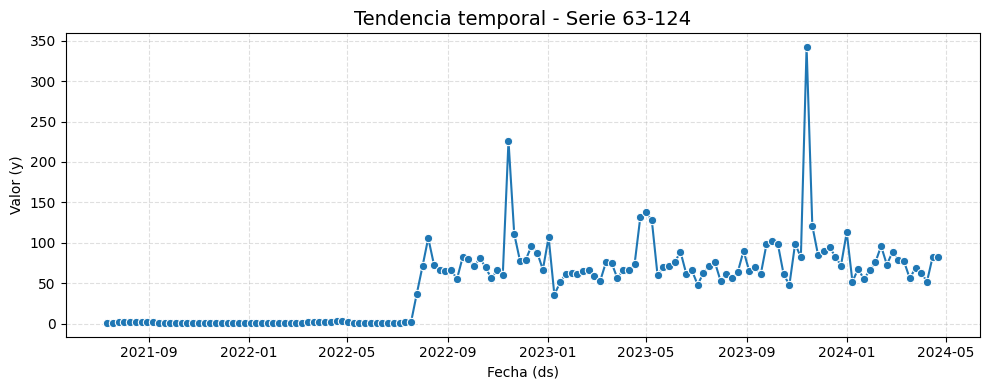

In [38]:
# graficar "63-124", serie que tiene de los mayores errores y que además tenía de los mayores ranking de forecastibilidad
unique_id_plot = "63-124"
df_to_plot = data[data["unique_id"] == unique_id_plot].sort_values("ds")

plt.figure(figsize=(10, 4))
sns.lineplot(data=df_to_plot, x="ds", y="y", marker="o", linewidth=1.5)

plt.title(f"Tendencia temporal - Serie {unique_id_plot}", fontsize=14)
plt.xlabel("Fecha (ds)")
plt.ylabel("Valor (y)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [39]:
df_to_plot

,unique_id,ds,y,Store,Product
78626,63-124,2021-07-12,1.0,63,124
78627,63-124,2021-07-19,1.0,63,124
78628,63-124,2021-07-26,2.0,63,124
78629,63-124,2021-08-02,2.0,63,124
78630,63-124,2021-08-09,2.0,63,124
...,...,...,...,...,...
78767,63-124,2024-03-25,69.0,63,124
78768,63-124,2024-04-01,63.0,63,124
78769,63-124,2024-04-08,52.0,63,124
78770,63-124,2024-04-15,83.0,63,124


In [46]:
df_debugging = data_fcst_real_test_backtest[data_fcst_real_test_backtest["unique_id"] == unique_id_plot]
df_debugging

,unique_id,ds,y_true,forecast,forecast_int,week0_update,horizonte_fcst
1590,63-124,2023-06-12,89.0,105.569920,106.0,2023-06-05,1.0
1591,63-124,2023-06-19,62.0,106.995964,107.0,2023-06-05,2.0
1592,63-124,2023-06-26,66.0,103.465699,103.0,2023-06-05,3.0
1590,63-124,2023-06-19,62.0,96.447176,96.0,2023-06-12,1.0
1591,63-124,2023-06-26,66.0,113.935520,114.0,2023-06-12,2.0
...,...,...,...,...,...,...,...
1591,63-124,2024-04-08,52.0,82.106695,82.0,2024-03-25,2.0
1592,63-124,2024-04-15,83.0,81.342902,81.0,2024-03-25,3.0
1590,63-124,2024-04-08,52.0,81.126344,81.0,2024-04-01,1.0
1591,63-124,2024-04-15,83.0,70.427368,70.0,2024-04-01,2.0


In [47]:
df_debugging.to_csv(f"{folder_forecasts}/df_debugging.csv")